In [11]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 

### Импорт

Через Kaggle API

In [15]:
!kaggle datasets download -d mirichoi0218/insurance
!unzip insurance.zip 
!rm insurance.zip
%ll -ht

  0%|                                               | 0.00/16.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 7.37MB/s]
Archive:  insurance.zip
  inflating: insurance.csv           
total 616K
-rw-rw-r-- 1 gladkov 553K Mar 11 06:10 insurance.ipynb
-rw-rw-r-- 1 gladkov   11 Mar 11 06:00 README.md
-rw-rw-r-- 1 gladkov  55K Sep 27  2019 insurance.csv


### IDA

In [16]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Выборка неравновесная - курильщиков сильно больше
Максимальное количество детей - пять.

In [49]:
df.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


По регионам и полу группы более-менее сбалансированы.

In [69]:
df.groupby(['region', 'sex']).count()

age  bmi  children  smoker  charges
region    sex                                        
northeast female  161  161       161     161      161
          male    163  163       163     163      163
northwest female  164  164       164     164      164
          male    161  161       161     161      161
southeast female  175  175       175     175      175
          male    189  189       189     189      189
southwest female  162  162       162     162      162
          male    163  163       163     163      163

NA нет

In [75]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Распределение по стоимости страховки - даже близко не нормально.
Страховка может сильно зависить от возраста, слабее от bmi.
bmi слабо коррелирует с возрастом.

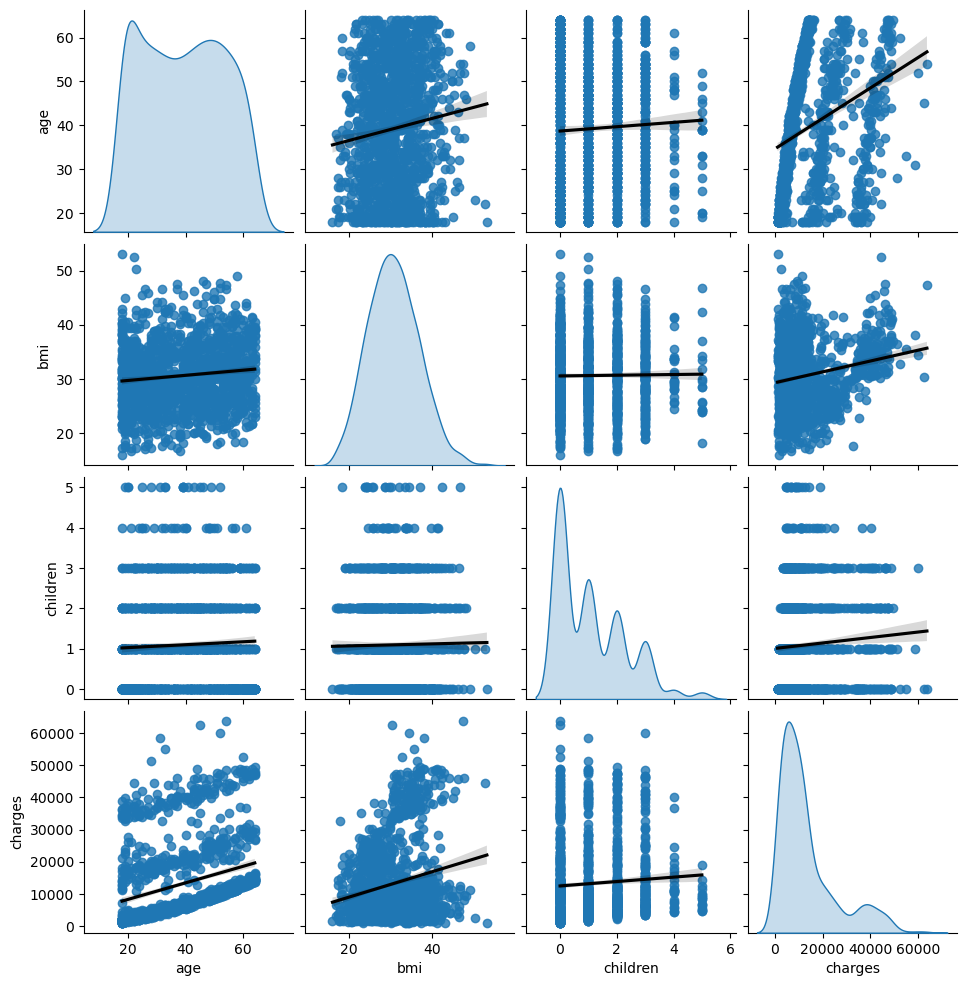

In [98]:
sns.pairplot(df, kind='reg', diag_kind='kde', plot_kws= {'line_kws': {'color':'black'}})

По регионам примерно одно и то же. 

Страховка для курильщиков выше.
Для курильщиков бимодальное распределение?

?Три кластера - низкая стоимость страховки, около 20k, около 40k


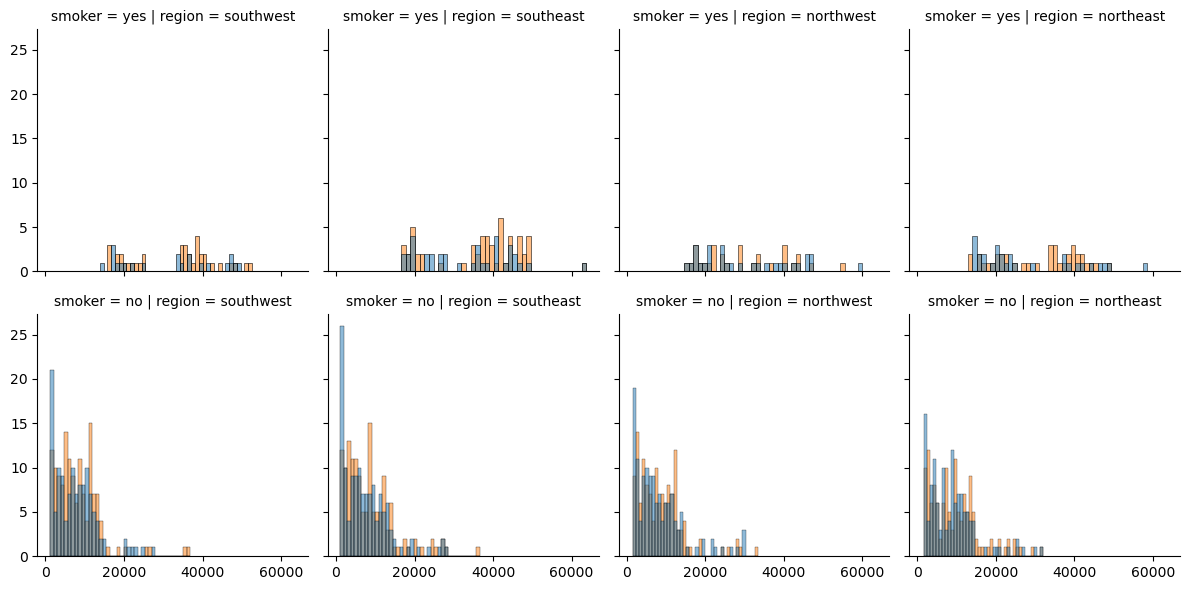

In [54]:
g = sns.FacetGrid(df, col="region", row="smoker")
g.map_dataframe(sns.histplot, x="charges", hue="sex", bins=40)

По возрасту равномерное распределение с пиком на 18-19.

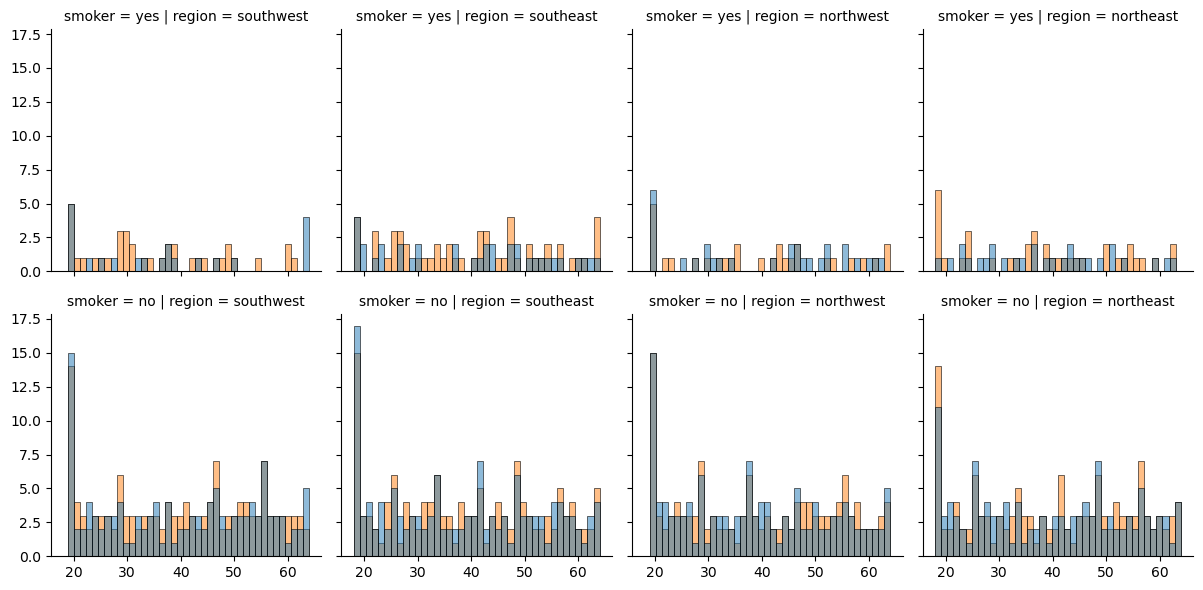

In [76]:
g = sns.FacetGrid(df, col="region", row="smoker")
g.map_dataframe(sns.histplot, x="age", hue="sex", bins=40)

Распределение по жирности нормальное.

?В southeast лиди толще?

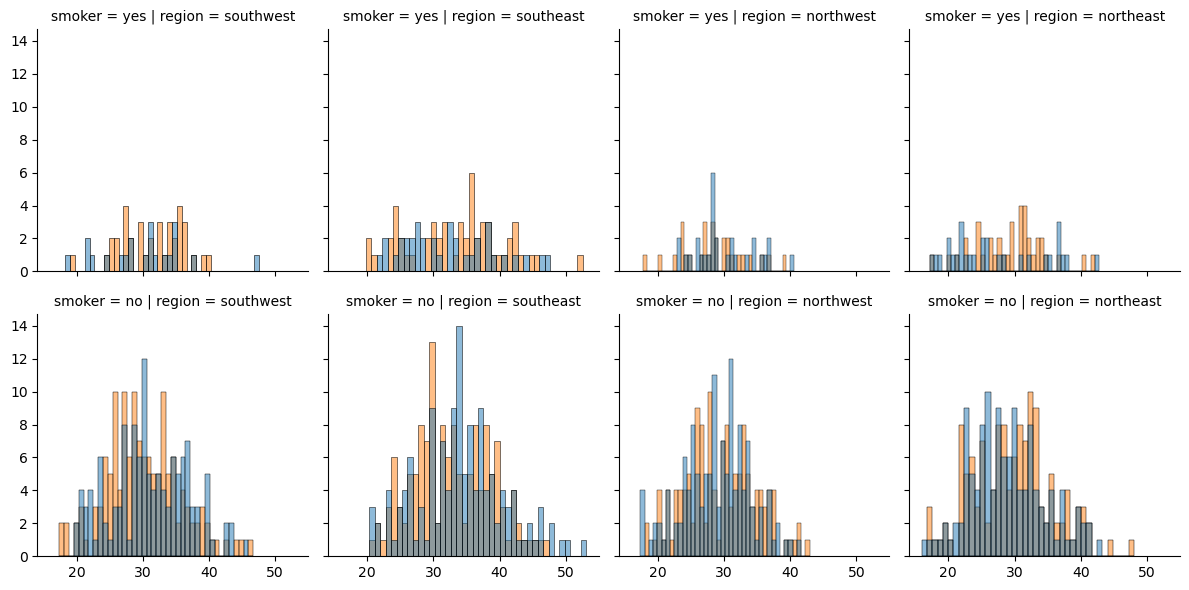

In [78]:
g = sns.FacetGrid(df, col="region", row="smoker")
g.map_dataframe(sns.histplot, x="bmi", hue="sex", bins=40)

Количество детей по региону и полу.

Различия в поле не заметно. Мужики не бросают насовсем?\
По региону тоже не заметно различий(?northwest)

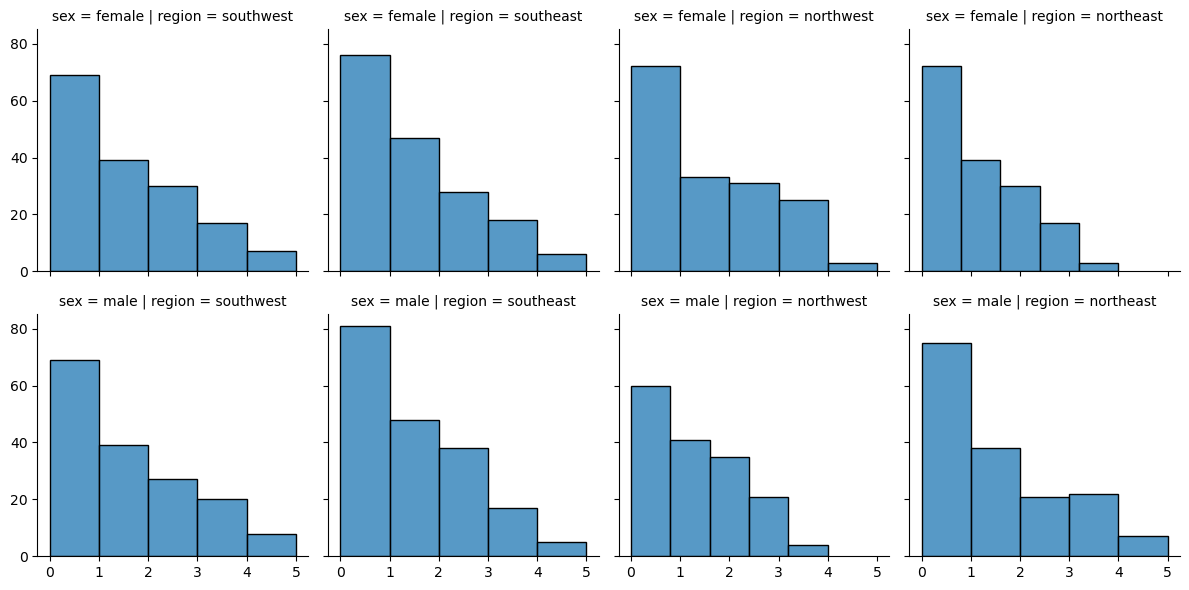

In [81]:
g = sns.FacetGrid(df, col="region", row="sex")
g.map_dataframe(sns.histplot, x="children", bins=5)

### Разделение датасета на train/test

https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

In [217]:
msk = np.random.rand(len(df)) < 0.75

train = df[msk]
test = df[~msk]

print(len(test), len(train))

332 1006


In [86]:
msk

array([False,  True,  True, ..., False,  True, False])

### Линмодели

charges от age.\
https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5 \
https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9


<AxesSubplot:xlabel='age', ylabel='charges'>

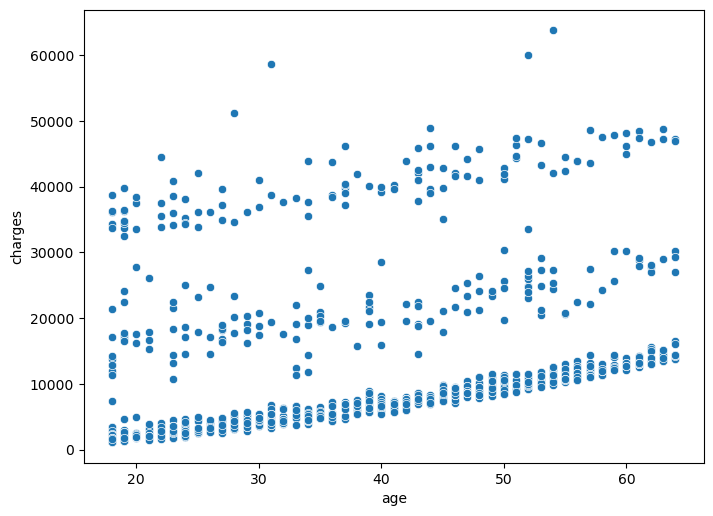

In [113]:
sns.scatterplot(data=train, y='charges', x='age')

In [226]:
X = pd.DataFrame(train['charges'])
y = pd.DataFrame(train['age'])

model = LinearRegression()
model = model.fit(X, y)

In [122]:
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [136]:
print('Coefficients: \n', r2_score(X, y))

Coefficients: 
 -1.1939421139771542


Через statmodels

In [154]:
sm_model = sm.OLS(X, y)
results = sm_model.fit()
results.pvalues

age    3.951600e-256
dtype: float64

In [155]:
results.rsquared_adj

0.5825730282101754

In [160]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.583
Model:                            OLS   Adj. R-squared (uncentered):              0.583
Method:                 Least Squares   F-statistic:                              1868.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                   3.95e-256
Time:                        05:29:11   Log-Likelihood:                         -14421.
No. Observations:                1338   AIC:                                  2.884e+04
Df Residuals:                    1337   BIC:                                  2.885e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          329.2873      7.618     43.224      0.000     314.343     344.232
==============================================================================
Omnibus:                      393.480   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              840.455
Skew:                           1.714   Prob(JB):                    3.14e-183
Kurtosis:                       4.823   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Mножественная



Sex, Smoke в dummy

In [229]:
train_mod = train.copy()
train_mod['sex_d'] = pd.get_dummies(train['sex'])['male'].values
train_mod['smoke_d'] = pd.get_dummies(train['smoker'])['yes'].values
train_mod

,age,sex,bmi,children,smoker,region,charges,sex_d,smoke_d
1,18,male,33.77,1,no,southeast,1725.55230,1,0
4,32,male,28.88,0,no,northwest,3866.85520,1,0
5,31,female,25.74,0,no,southeast,3756.62160,0,0
8,37,male,29.83,2,no,northeast,6406.41070,1,0
9,60,female,25.84,0,no,northwest,28923.13692,0,0
...,...,...,...,...,...,...,...,...,...
1332,52,female,44.70,3,no,southwest,11411.68500,0,0
1333,50,male,30.97,3,no,northwest,10600.54830,1,0
1334,18,female,31.92,0,no,northeast,2205.98080,0,0
1335,18,female,36.85,0,no,southeast,1629.83350,0,0


In [230]:
y = train_w['charges']
X = train_w[['age','bmi','children','sex_d']]
sm_model_mult = sm.OLS(y, X).fit()
sm_model_mult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.601
Method:                 Least Squares   F-statistic:                              380.5
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                   2.86e-199
Time:                        05:56:15   Log-Likelihood:                         -10817.
No. Observations:                1006   AIC:                                  2.164e+04
Df Residuals:                    1002   BIC:                                  2.166e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          207.0281     23.661      8.750      0.000     160.597     253.459
bmi          158.5149     33.795      4.691      0.000      92.199     224.831
children     249.0252    290.826      0.856      0.392    -321.672     819.722
sex_d        496.9792    709.789      0.700      0.484    -895.864    1889.822
==============================================================================
Omnibus:                      270.865   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.487
Skew:                           1.625   Prob(JB):                    1.06e-115
Kurtosis:                       4.440   Cond. No.                         102.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""